In [3]:
from ray.tune.examples.pbt_tune_cifar10_with_keras import num_classes

from load_data import load_data_from_folder, integrate_ankle_insole, process_camargo_data, normalize_ankle_angle

2025-04-24 20:25:14.644201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745526314.708206    3358 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745526314.725293    3358 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 20:25:14.877467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
camargo_ds = process_camargo_data("camargo/data/")

Processing camargo:   0%|          | 0/1237 [00:00<?, ?it/s]

In [30]:
def vote_activity(imu_data):
    activities = [data.activity for data in imu_data]
    activity_counts = {activity: activities.count(activity) for activity in set(activities)}
    # sort by count
    sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)
    # return the most common activity that is not idle
    for activity, count in sorted_activities:
        if activity != "idle" and '-' not in activity and activity != "stand":
            return activity

In [31]:
class Segment:
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
        self.data = []
        self.activity = None

    def add_data(self, data):
        self.data.append(data)
        if self.start_time == 0:
            self.start_time = data.timestep
        self.end_time = data.timestep

    def detect_activity(self):
        if self.data:
            self.activity = vote_activity(self.data) or "misc"
            if self.end_time-self.start_time > 3:
                self.activity = "misc"
            if "turn" in self.activity:
                self.activity = "walk"
        else:
            self.activity = None

    def interval(self):
        return self.end_time - self.start_time

In [48]:
segments = []
for dataset in camargo_ds:
    current_segment = Segment()
    integrate_ankle_insole(dataset)
    for data in dataset:
        if data.heel_striking:
            if current_segment.data:
                segments.append(current_segment)
            current_segment = Segment()
        current_segment.add_data(data)
    segments.append(current_segment)

In [49]:
# add segments to dataset
from dataset import StrideClassificationDataset
training_ds = StrideClassificationDataset(segments)
print(len(training_ds))

15404


In [50]:
num_classes = len(training_ds.get_label_encoder().classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [51]:
training_ds.get_label_encoder().classes_

array(['misc', 'rampascent', 'rampdescent', 'stairascent', 'stairdescent',
       'walk'], dtype='<U12')

In [52]:
from collections import Counter
print(Counter(seg.activity for seg in segments))

Counter({'misc': 6295, 'walk': 2982, 'rampdescent': 2231, 'rampascent': 2051, 'stairascent': 925, 'stairdescent': 920})


In [53]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Split dataset into train, validation, and test sets
indices = list(range(len(training_ds)))
labels = [training_ds[i][1] for i in indices]

# 70% train, 15% val, 15% test
train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

val_test_labels = [labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=val_test_labels,
    random_state=42
)

train_subset = Subset(training_ds, train_indices)
val_subset = Subset(training_ds, val_indices)
test_subset = Subset(training_ds, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import StrideClassificationCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StrideClassificationCNN(input_channels=7, num_classes=len(training_ds.get_label_encoder().classes_)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1, Loss: 0.3713, Val Acc: 0.9559
Epoch 2, Loss: 0.1569, Val Acc: 0.9632
Epoch 3, Loss: 0.1263, Val Acc: 0.9732
Epoch 4, Loss: 0.0995, Val Acc: 0.9736
Epoch 5, Loss: 0.0846, Val Acc: 0.9641
Epoch 6, Loss: 0.0706, Val Acc: 0.9762
Epoch 7, Loss: 0.0625, Val Acc: 0.9792
Epoch 8, Loss: 0.0596, Val Acc: 0.9818
Epoch 9, Loss: 0.0672, Val Acc: 0.9831
Epoch 10, Loss: 0.0423, Val Acc: 0.9840
Epoch 11, Loss: 0.0424, Val Acc: 0.9667
Epoch 12, Loss: 0.0371, Val Acc: 0.9792
Epoch 13, Loss: 0.0390, Val Acc: 0.9762
Epoch 14, Loss: 0.0325, Val Acc: 0.9732
Epoch 15, Loss: 0.0332, Val Acc: 0.9844
Epoch 16, Loss: 0.0342, Val Acc: 0.9762
Epoch 17, Loss: 0.0304, Val Acc: 0.9840
Epoch 18, Loss: 0.0390, Val Acc: 0.9887
Epoch 19, Loss: 0.0348, Val Acc: 0.9900
Epoch 20, Loss: 0.0205, Val Acc: 0.9883
Epoch 21, Loss: 0.0273, Val Acc: 0.9866
Epoch 22, Loss: 0.0236, Val Acc: 0.9853
Epoch 23, Loss: 0.0278, Val Acc: 0.9883
Epoch 24, Loss: 0.0152, Val Acc: 0.9844
Epoch 25, Loss: 0.0315, Val Acc: 0.9857
Epoch 26,

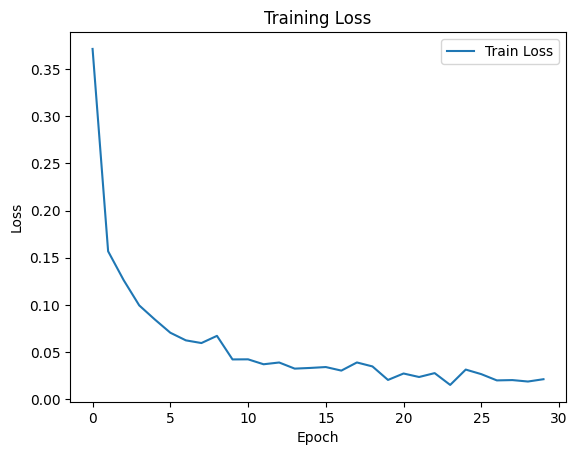

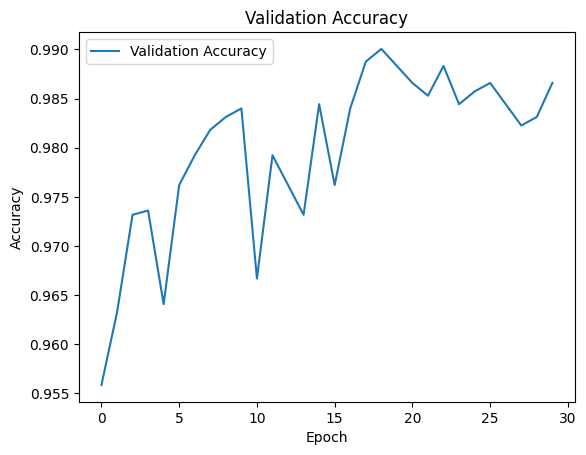

In [39]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Evaluate on validation set
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu()
            val_preds.extend(preds.numpy())
            val_labels.extend(y_batch.numpy())
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [40]:
# save model
torch.save(model.state_dict(), "stride_classification_model.pth")

In [56]:
# load model
model = StrideClassificationCNN(input_channels=7, num_classes=len(training_ds.get_label_encoder().classes_)).to(device)
model.load_state_dict(torch.load("stride_classification_model.pth"))

/tmp/ipykernel_3358/926083013.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("stride_classification_model.pth"))


<All keys matched successfully>

In [57]:
# Final evaluation on test set
from sklearn.metrics import classification_report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Decode and print classification report
label_encoder = training_ds.get_label_encoder()
labels = list(range(len(label_encoder.classes_)))
print("Test Classification Report:")
print(classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_))

Test Classification Report:
              precision    recall  f1-score   support

        misc       0.99      0.99      0.99       944
  rampascent       1.00      0.99      1.00       307
 rampdescent       0.99      1.00      1.00       335
 stairascent       0.99      0.97      0.98       139
stairdescent       0.98      0.98      0.98       138
        walk       1.00      0.98      0.99       448

    accuracy                           0.99      2311
   macro avg       0.99      0.99      0.99      2311
weighted avg       0.99      0.99      0.99      2311



In [42]:
michael_walk_data, insole_data, _ = load_data_from_folder("data/04_03_walk/", [50,159], [149,202], 0, 30.5731)
integrate_ankle_insole(michael_walk_data, insole_data)
michael_walk_data = normalize_ankle_angle(michael_walk_data)
for data in michael_walk_data:
    data.activity = "walk"

michael_downramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [10,43], [20,55], 0, -0.8789)
integrate_ankle_insole(michael_downramp_data, insole_data)
michael_downramp_data = normalize_ankle_angle(michael_downramp_data)
for data in michael_downramp_data:
    data.activity = "rampdescent"

michael_upramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [23,62], [34,71], 0, -0.8789)
integrate_ankle_insole(michael_upramp_data, insole_data)
michael_upramp_data = normalize_ankle_angle(michael_upramp_data)
for data in michael_upramp_data:
    data.activity = "rampascent"

michael_downstairs_data, insole_data, _ = load_data_from_folder("data/01_22_downstairs/", 20, 1e9, 0, 0.3675)
integrate_ankle_insole(michael_downstairs_data, insole_data)
michael_downstairs_data = normalize_ankle_angle(michael_downstairs_data)
for data in michael_downstairs_data:
    data.activity = "stairdescent"

michael_upstairs_data, insole_data, _ = load_data_from_folder("data/01_22_upstairs/", 0, 1e9, 0, 2.5461)
integrate_ankle_insole(michael_upstairs_data, insole_data)
michael_upstairs_data = normalize_ankle_angle(michael_upstairs_data)
for data in michael_upstairs_data:
    data.activity = "stairascent"

mohsen_walk_data, insole_data, _ = load_data_from_folder("data/04_14_walk_stair_vending/", 0, 1e9, 0, -60.3619)
integrate_ankle_insole(mohsen_walk_data, insole_data)
mohsen_walk_data = normalize_ankle_angle(mohsen_walk_data)
for data in mohsen_walk_data:
    data.activity = "walk"

mohsen_walk_data2, insole_data, _ = load_data_from_folder("data/04_14_walk_vending_stair/", 0, 1e9, 0, -6.8690)
integrate_ankle_insole(mohsen_walk_data2, insole_data)
mohsen_walk_data2 = normalize_ankle_angle(mohsen_walk_data2)
for data in mohsen_walk_data2:
    data.activity = "walk"

mohsen_walk_data3, insole_data, _ = load_data_from_folder("data/04_14_outdoor_fitz_walk/", 0, 1e9, 0, -7.9118)
integrate_ankle_insole(mohsen_walk_data3, insole_data)
mohsen_walk_data3 = normalize_ankle_angle(mohsen_walk_data3)
for data in mohsen_walk_data3:
    data.activity = "walk"

mohsen_walk_data4, insole_data, _ = load_data_from_folder("data/04_14_walk_fitz_bond/", 0, 1e9, 0, -35.8358)
integrate_ankle_insole(mohsen_walk_data4, insole_data)
mohsen_walk_data4 = normalize_ankle_angle(mohsen_walk_data4)
for data in mohsen_walk_data4:
    data.activity = "walk"

mohsen_walk_data5, insole_data, _ = load_data_from_folder("data/04_14_walk_main_fitz/", 0, 1e9, 0, 3.4172)
integrate_ankle_insole(mohsen_walk_data5, insole_data)
mohsen_walk_data5 = normalize_ankle_angle(mohsen_walk_data5)
for data in mohsen_walk_data5:
    data.activity = "walk"

mohsen_downramp_data1, insole_data, _ = load_data_from_folder("data/04_14_downramp_bond_x2/", 0, 1e9, 0, -22.4661)
integrate_ankle_insole(mohsen_downramp_data1, insole_data)
mohsen_downramp_data1 = normalize_ankle_angle(mohsen_downramp_data1)
for data in mohsen_downramp_data1:
    data.activity = "rampdescent"

mohsen_downramp_data2, insole_data, _ = load_data_from_folder("data/04_14_downramp_lake/", 0, 1e9, 0, -7.1484)
integrate_ankle_insole(mohsen_downramp_data2, insole_data)
mohsen_downramp_data2 = normalize_ankle_angle(mohsen_downramp_data2)
for data in mohsen_downramp_data2:
    data.activity = "rampdescent"

mohsen_downramp_data3, insole_data, _ = load_data_from_folder("data/04_14_downramp_columba_hall/", 0, 1e9, 0, 2.3692)
integrate_ankle_insole(mohsen_downramp_data3, insole_data)
mohsen_downramp_data3 = normalize_ankle_angle(mohsen_downramp_data3)
for data in mohsen_downramp_data3:
    data.activity = "rampdescent"

mohsen_upramp_data1, insole_data, _ = load_data_from_folder("data/04_14_upramp_bond_x2/", 0, 1e9, 0, 1.4235)
integrate_ankle_insole(mohsen_upramp_data1, insole_data)
mohsen_upramp_data1 = normalize_ankle_angle(mohsen_upramp_data1)
for data in mohsen_upramp_data1:
    data.activity = "rampascent"

mohsen_upramp_data2, insole_data, _ = load_data_from_folder("data/04_14_upramp_lake/", 0, 1e9, 0, 2.7880)
integrate_ankle_insole(mohsen_upramp_data2, insole_data)
mohsen_upramp_data2 = normalize_ankle_angle(mohsen_upramp_data2)
for data in mohsen_upramp_data2:
    data.activity = "rampascent"

mohsen_upramp_data3, insole_data, _ = load_data_from_folder("data/04_14_upramp_columba_hall/", 0, 1e9, 0, -7.3961)
integrate_ankle_insole(mohsen_upramp_data3, insole_data)
mohsen_upramp_data3 = normalize_ankle_angle(mohsen_upramp_data3)
for data in mohsen_upramp_data3:
    data.activity = "rampascent"

mohsen_upstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_upstairs_leftfoot_main/", 0, 1e9, 0, -13.6291)
integrate_ankle_insole(mohsen_upstairs_data1, insole_data)
mohsen_upstairs_data1 = normalize_ankle_angle(mohsen_upstairs_data1)
for data in mohsen_upstairs_data1:
    data.activity = "stairascent"

mohsen_upstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_upstairs_rightfoot_main/", 0, 1e9, 0, -11.0419)
integrate_ankle_insole(mohsen_upstairs_data2, insole_data)
mohsen_upstairs_data2 = normalize_ankle_angle(mohsen_upstairs_data2)
for data in mohsen_upstairs_data2:
    data.activity = "stairascent"

mohsen_downstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_downstairs_leftfoot_main/", 0, 1e9, 0, 9.3960)
integrate_ankle_insole(mohsen_downstairs_data1, insole_data)
mohsen_downstairs_data1 = normalize_ankle_angle(mohsen_downstairs_data1)
for data in mohsen_downstairs_data1:
    data.activity = "stairdescent"

mohsen_downstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_downstairs_rightfoot_main/", 0, 1e9, 0, 5.0417)
integrate_ankle_insole(mohsen_downstairs_data2, insole_data)
mohsen_downstairs_data2 = normalize_ankle_angle(mohsen_downstairs_data2)
for data in mohsen_downstairs_data2:
    data.activity = "stairdescent"

michael_data = michael_walk_data + michael_downramp_data + michael_upramp_data + michael_downstairs_data + michael_upstairs_data
mohsen_data = mohsen_walk_data + mohsen_walk_data2 + mohsen_walk_data3 + mohsen_walk_data4 + mohsen_walk_data5 + \
    mohsen_downramp_data1 + mohsen_downramp_data2 + mohsen_downramp_data3 + \
    mohsen_upramp_data1 + mohsen_upramp_data2 + mohsen_upramp_data3 + \
    mohsen_upstairs_data1 + mohsen_upstairs_data2 + \
    mohsen_downstairs_data1 + mohsen_downstairs_data2

In [58]:
segments = []
current_segment = Segment()
for data in mohsen_data:
    if data.heel_striking:
        if current_segment.data:
            segments.append(current_segment)
        current_segment = Segment()
    current_segment.add_data(data)
segments.append(current_segment)
training_ds = StrideClassificationDataset(segments)

In [59]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Split dataset into train, validation, and test sets
indices = list(range(len(training_ds)))
labels = [training_ds[i][1] for i in indices]

# 70% train, 30%
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.7,
    stratify=labels,
    random_state=42
)

train_subset = Subset(training_ds, train_indices)
test_subset = Subset(training_ds, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Epoch 1, Loss: 3.5011
Epoch 2, Loss: 0.8276
Epoch 3, Loss: 0.7601
Epoch 4, Loss: 0.7206
Epoch 5, Loss: 0.6656
Epoch 6, Loss: 0.5990
Epoch 7, Loss: 0.5508
Epoch 8, Loss: 0.5183
Epoch 9, Loss: 0.5425
Epoch 10, Loss: 0.5111
Epoch 11, Loss: 0.4920
Epoch 12, Loss: 0.4696
Epoch 13, Loss: 0.4261
Epoch 14, Loss: 0.4601
Epoch 15, Loss: 0.4166


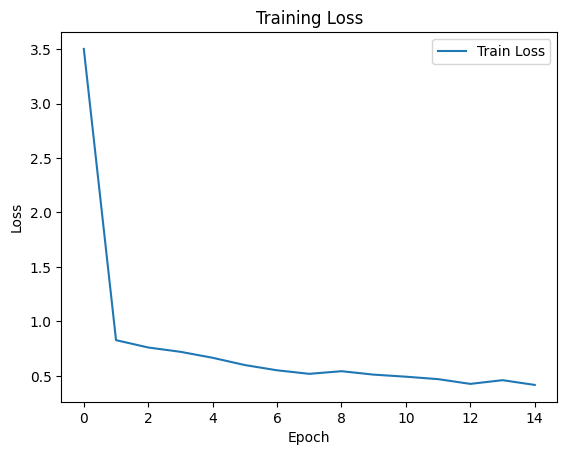

In [45]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

for epoch in range(15):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [60]:
# Final evaluation on test set
from sklearn.metrics import classification_report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Decode and print classification report
label_encoder = training_ds.get_label_encoder()
labels = list(range(len(label_encoder.classes_)))
print("Test Classification Report:")
print(classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_))

Test Classification Report:
              precision    recall  f1-score   support

        misc       0.01      1.00      0.02         8
  rampascent       0.21      0.28      0.24       159
 rampdescent       1.00      0.01      0.02       169
 stairascent       0.38      0.29      0.32        42
stairdescent       0.76      0.37      0.50        35
        walk       0.52      0.02      0.03       698

    accuracy                           0.08      1111
   macro avg       0.48      0.33      0.19      1111
weighted avg       0.55      0.08      0.09      1111

